In [16]:
%matplotlib inline
from training_tools.train_models import train_models
from training_tools.evaluate_models import evaluate_models
from training_tools.helpers.plotting import load_results, plot_metrics
from training_tools.normalize_and_align_models import normalize_and_align_vectors
from training_tools.helpers.plotting import load_results, plot_metrics
from training_tools.w2v_model import W2VModel
from training_tools.helpers.cosine_similarity_time_series import cosine_similarity_over_years
from training_tools.helpers.weat_time_series import compute_weat_over_years

# **Train `Word2vec` Models**
## **Goal**: Train and evaluate word embeddings using the `Word2vec` algorithm. 

If you have successfully run the two previous workflows (`workflow_unigrams.ipynb` and `workflow_multigrams.ipynb`), then you are in possession of pre-processed yearly Google Ngram data. This workflow uses the `train_models.py` module to train year-specific models using [Word2Vec](https://en.wikipedia.org/wiki/Word2vec)—a popular technique for deriving [vector representations](https://en.wikipedia.org/wiki/Word_embedding) of the words in a corpus. You can then use the `evaluate_models.py` module to see how well your models have been trained.

Training word-embedding models requires decisions about various modeling parameters (i.e., hyperparameters). The most important are:

1. **`vector_size`**: the dimensionality of the vector space in which words are embedded. In essence, vector size is the number of words _in relation to which_ the model understands any particular word. More dimensions are not necessarily better. While too few dimensions can prevent the model from learning words' full meanings, too many dimensions risks overfitting or allowing low-frequency, specialized uses to obscure words' most important meanings.

2. **`window`**: the width of `word2vec`'s sliding context window. Word2vec reads in "sentences" (in this case, multigrams) and tries to learn probabilistic relationships between a target word and the words that surround it in the corpus. To the extent that two words have the same probabilistic relations to other nearby words, their vector representations will be similar. The `window` parameter determines what "nearby" means: With a window of 2, a word's meaning is defined strictly by the words immediately adjacent to it; with a window of 5, a word's meaning is determined by words up to four words away. Roughly speaking, models trained using a narrow context window will privilege _syntactic_ relationships, whereas models trained using a wider context window will do a better job learning _semantic_ relationships.

3. **`approach`**: the training architecture to use. You can specify either `CBOW` (Continuous Bag of Words) or `skip-gram`. In CBOW, context words are used to predict target words; in `skip-gram`, target words are used to predict context words. `skip-gram` tends to yield better results with ngrams.

4. **`min_count`**: the minimum number of times a word must appear in the corpus to be used for training. You may wish to ignore extremely infrequent words—especially in large corpora. This parameter lets you do that.

5. **`weight_by`**: the strategy for weighting ngrams by their frequency in the corpus. `none` means that no weighting is used and each unique ngram is fed to the model only once. `freq` gives ngrams a "bonus" if they appear multiple times; however the bonus diminishes as the frequency increases. For example, an ngram appearing 100 times in the corpus will be fed to `word2vec` twice, an ngram appearing 1,000 times is fed to the model 3 times, an ngram appearing 10,000 is fed to the model 4 times, and so on. The `doc_freq` option does the same thing, but using the number of unique _documents_ ngrams appear in. The goal of weighting is to allow somewhat frequent ngrams to influence the model more than rare ones—while not letting extremely frequent ngrams skew the model.

6. **`epochs`**: the number of training passes over the corpus. Too many can lead to overfitting, while too few can lead to imprecise embeddings. Experiment to see which values lead to the best model performance.

The other options are straightforward. `proj_dir` is the base directory for your project, `years=([start_year], [end_year])` specifies which yearly models to train, and `workers` is the number of CPU cores to use.

### Train Models
The `train_models.py` module can be used to iterate through multiple parameter combinations—allowing you to conduct a [grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization). Thus, if you want to train models for 2018 and 2019 using vector sizes of 100, 200, and 300 and all three weighting strategies, you would specify `year=(2018, 2019)`, `weight_by=('none', 'freq', 'doc_freq')` and `vector_size=(100, 200, 300)`. The module would then train models using all combinations of these parameters, for a total of 18 models.

In [ ]:
train_models(
    ngram_size=5,
    proj_dir='/vast/edk202/NLP_corpora/Google_Books/20200217/eng-fiction/',
    years=(2019, 2019),
    weight_by=('none'),
    vector_size=(100, 200, 300, 400, 500),
    window=5,
    workers=14,
    min_count=(1),
    approach=('skip-gram'),
    epochs=(5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)
)

Start Time:         2025-02-05 11:24:05.817061

Training Info
Data directory:     /vast/edk202/NLP_corpora/Google_Books/20200217/eng-fiction/5gram_files/6corpus/yearly_files/data
Model directory:    /vast/edk202/NLP_corpora/Google_Books/20200217/eng-fiction/5gram_files/6corpus/yearly_files/models
Log directory:      /vast/edk202/NLP_corpora/Google_Books/20200217/eng-fiction/5gram_files/6corpus/yearly_files/logs/training
Ngram size:         5
Number of workers:  14

Grid paramters:
  Weighting:           ('none',)
  Vector size:         (100, 200, 300, 400, 500)
  Context window:      (5,)
  Minimum word count:  (1,)
  Approach:            ('skip-gram',)
  Training epochs:     (5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)



Training Models:   0%|          | 0/55 [00:00<?, ?it/s]

### Evaluate Training Quality
The next step is to examine the quality of the trained models. The `evaluate_models.py` module performs two "intrinsic" tests on the models in your project's `models` directory: a similarity test and an analogy test. In a similarity test, models predict human-rated similarities between word pairs. In an analogy test, models attempt to answer questions of the form "_a_ is to _b_ as _c_ is to what?"—for example, "_king_ is to _queen_ as _man_ is to what?" (where the correct answer is _woman_).

By default, the code runs the similarity tests packaged with Gensim, but if you want to use different test items, you can by specifying the `similarity_dataset` and `analogy_dataset` options (making sure that the test files are properly formatted).

In [ ]:
evaluate_models(
    ngram_size=5,
    proj_dir='/vast/edk202/NLP_corpora/Google_Books/20200217/eng/',
    eval_dir='/scratch/edk202/hist_w2v/training_results',
    save_mode='append',
    workers=48
)

### Plot Metrics

In [ ]:
results_df = load_results('../training_results/evaluation_results.csv')

plot_metrics(
    df=results_df,
    x_vars=['year'],
    plot_type='line',
    metric='similarity_score'
)

In [ ]:
results_df = load_results('../training_results/evaluation_results.csv')

plot_metrics(
    df=results_df,
    x_vars=['year'],
    plot_type='line',
    metric='analogy_score'
)

In [ ]:
normalize_and_align_vectors(
    ngram_size=5,
    proj_dir='/vast/edk202/NLP_corpora/Google_Books/20200217/eng/',
    anchor_year=2019
)

In [5]:
model1 = W2VModel("/vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/6corpus/yearly_files/models/norm_and_align/w2v_y2015_wbnone_vs200_w5_mc20_sg1_e10.kv")
model2 = W2VModel("/vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/6corpus/yearly_files/models/norm_and_align/w2v_y2019_wbnone_vs200_w5_mc20_sg1_e10.kv")

# Ensure vocab is filtered before evaluation
reference_vocab = model1.extract_vocab().intersection(model2.extract_vocab())
model1.filter_vocab(reference_vocab)
model2.filter_vocab(reference_vocab)

# Evaluate alignment
alignment_results = model1.evaluate_alignment(model2)


---------------- Normalization and Alignment Evaluation ------------------
Model1 normalized: True
Model2 normalized: True
Shared vocabulary size: 77216
Filtered vocabularies match: True
Shape of X (anchor model vectors): (77216, 200)
Shape of Y (target model vectors): (77216, 200)
Alignment deviation from identity: 0.000154
⚠️ Alignment deviation is small but nonzero. Check vocabulary consistency.
Models are aligned (threshold 0.001): True
--------------------------------------------------------------------------



In [6]:
model = W2VModel("/vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/6corpus/yearly_files/models/norm_and_align/w2v_y2019_wbnone_vs200_w5_mc20_sg1_e10.kv")

word1 = "mao"
word2 = "capitalist"

try:
    similarity = model.cosine_similarity(word1, word2)
    print(f"Cosine similarity between '{word1}' and '{word2}': {similarity:.4f}")
except KeyError as e:
    print(e)

Cosine similarity between 'mao' and 'capitalist': 0.2460


'hispanic' missing in models for years: 1901, 1902


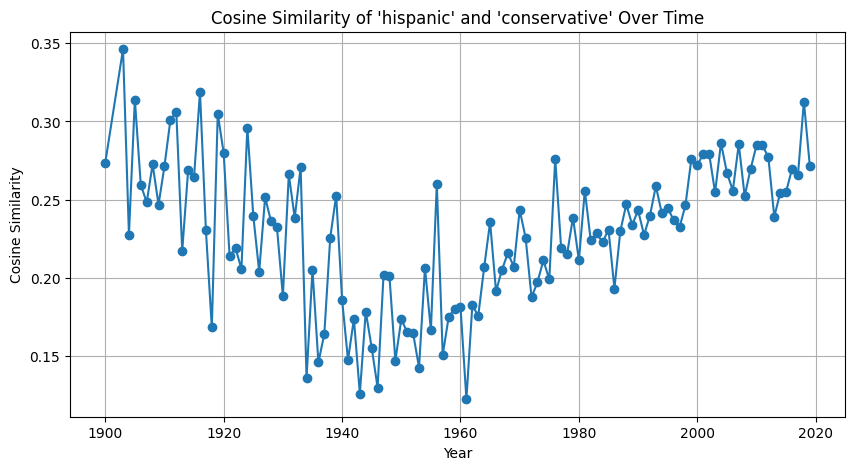

{1900: 0.27354354,
 1903: 0.34623668,
 1904: 0.22755064,
 1905: 0.31394327,
 1906: 0.25932997,
 1907: 0.24822724,
 1908: 0.27257568,
 1909: 0.24676749,
 1910: 0.27130198,
 1911: 0.3008815,
 1912: 0.3061178,
 1913: 0.21715376,
 1914: 0.26884088,
 1915: 0.26452133,
 1916: 0.31890592,
 1917: 0.23029599,
 1918: 0.16808642,
 1919: 0.30497324,
 1920: 0.27984834,
 1921: 0.21380581,
 1922: 0.21895678,
 1923: 0.20549476,
 1924: 0.29608706,
 1925: 0.23975725,
 1926: 0.20379661,
 1927: 0.25137782,
 1928: 0.23606704,
 1929: 0.23221079,
 1930: 0.18811381,
 1931: 0.2660221,
 1932: 0.23834643,
 1933: 0.27051476,
 1934: 0.13570793,
 1935: 0.2050624,
 1936: 0.14564635,
 1937: 0.16393125,
 1938: 0.22556385,
 1939: 0.25254416,
 1940: 0.1859611,
 1941: 0.14728881,
 1942: 0.17352054,
 1943: 0.12573428,
 1944: 0.17826645,
 1945: 0.15516943,
 1946: 0.12961246,
 1947: 0.20158298,
 1948: 0.20101929,
 1949: 0.14678478,
 1950: 0.17332418,
 1951: 0.16496618,
 1952: 0.1643103,
 1953: 0.14241244,
 1954: 0.20623839,

In [12]:
cosine_similarity_over_years(
    word1="hispanic",
    word2="conservative",
    start_year=1900,
    end_year=2019,
    model_dir="/vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/6corpus/yearly_files/models/norm_and_align/",
    plot=True
)

In [56]:
model = W2VModel("/vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/6corpus/yearly_files/models/norm_and_align/w2v_y2019_wbnone_vs200_w5_mc20_sg1_e10.kv")

category1 = ["science", "technology", "chemistry"]
category2 = ["art", "literature", "poetry", "painting"]
target1 = ["man", "male", "boy", "father", "brother"]
target2 = ["woman", "female", "girl", "mother", "sister"]

weat_score = model.compute_weat(category1, category2, target1, target2)
print(f"WEAT effect size (Cohen's d): {weat_score:.4f}")

WEAT effect size (Cohen's d): 0.4909


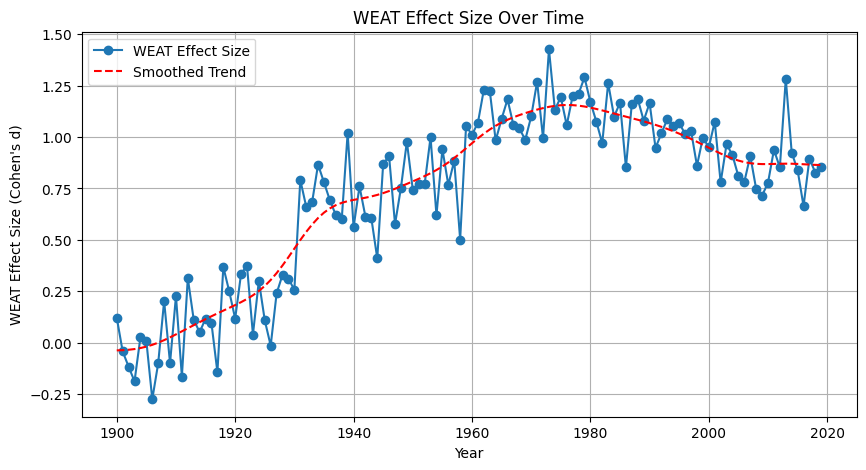

{1900: 0.12129343,
 1901: -0.042670533,
 1902: -0.1165637,
 1903: -0.18807939,
 1904: 0.026512986,
 1905: 0.008216129,
 1906: -0.27495188,
 1907: -0.100248344,
 1908: 0.20280248,
 1909: -0.099577725,
 1910: 0.2266292,
 1911: -0.16495986,
 1912: 0.31400886,
 1913: 0.111488126,
 1914: 0.0508159,
 1915: 0.11741418,
 1916: 0.0941241,
 1917: -0.14377888,
 1918: 0.36836952,
 1919: 0.2489112,
 1920: 0.11703515,
 1921: 0.3362089,
 1922: 0.3731055,
 1923: 0.03959105,
 1924: 0.30073854,
 1925: 0.10892201,
 1926: -0.014586533,
 1927: 0.23963878,
 1928: 0.33021906,
 1929: 0.31104952,
 1930: 0.25698215,
 1931: 0.7915982,
 1932: 0.6612264,
 1933: 0.6837865,
 1934: 0.8660582,
 1935: 0.7796623,
 1936: 0.69222534,
 1937: 0.62068284,
 1938: 0.5998717,
 1939: 1.0199496,
 1940: 0.56180793,
 1941: 0.76020324,
 1942: 0.6132744,
 1943: 0.60551447,
 1944: 0.40965065,
 1945: 0.8708818,
 1946: 0.905805,
 1947: 0.5760319,
 1948: 0.75333714,
 1949: 0.97733957,
 1950: 0.7442357,
 1951: 0.7730425,
 1952: 0.7701891,

In [11]:
model = W2VModel("/vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/6corpus/yearly_files/models/norm_and_align/w2v_y2019_wbnone_vs200_w5_mc20_sg1_e10.kv")

category1 = ["good", "ideal", "wonderful", "excellent", "great", "fantastic", "amazing", "superb", "outstanding", "marvelous", "splendid", "brilliant", "fabulous", "terrific", "admirable", "commendable", "exemplary", "praiseworthy", "superior", "stellar", "notable", "positive", "advantageous", "desirable"]
category2 = ["bad", "evil", "destructive", "terrible", "horrible", "awful", "dreadful", "abysmal", "atrocious", "appalling", "ghastly", "wicked", "villainous", "corrupt", "harmful", "damaging", "unethical", "deplorable", "noxious", "pernicious", "heinous", "malevolent", "diabolical", "negative", "undesirable"]
target1 = ["socialism", "socialist"]
target2 = ["capitalism", "capitalist"]

compute_weat_over_years(
    category1,
    category2,
    target1,
    target2,
    start_year=1900,
    end_year=2019,
    model_dir="/vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/6corpus/yearly_files/models/norm_and_align/",
    plot=True,
    smooth=True,
    sigma=5
)

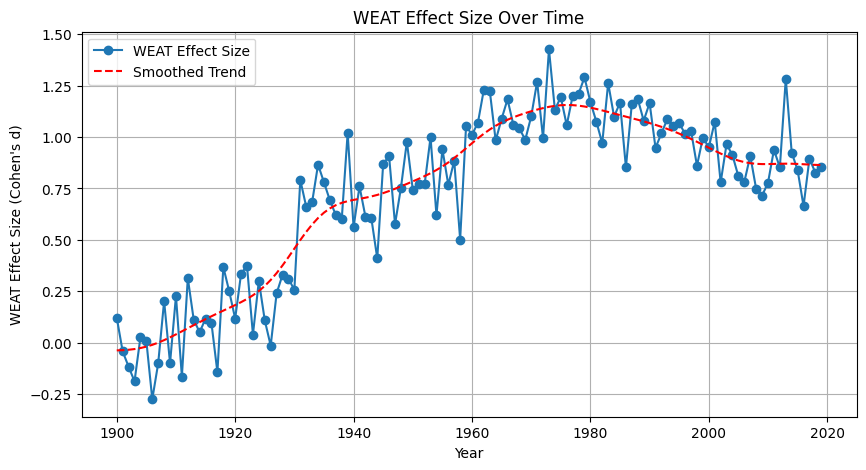

{1900: 0.12129343,
 1901: -0.042670533,
 1902: -0.1165637,
 1903: -0.18807939,
 1904: 0.026512986,
 1905: 0.008216129,
 1906: -0.27495188,
 1907: -0.100248344,
 1908: 0.20280248,
 1909: -0.099577725,
 1910: 0.2266292,
 1911: -0.16495986,
 1912: 0.31400886,
 1913: 0.111488126,
 1914: 0.0508159,
 1915: 0.11741418,
 1916: 0.0941241,
 1917: -0.14377888,
 1918: 0.36836952,
 1919: 0.2489112,
 1920: 0.11703515,
 1921: 0.3362089,
 1922: 0.3731055,
 1923: 0.03959105,
 1924: 0.30073854,
 1925: 0.10892201,
 1926: -0.014586533,
 1927: 0.23963878,
 1928: 0.33021906,
 1929: 0.31104952,
 1930: 0.25698215,
 1931: 0.7915982,
 1932: 0.6612264,
 1933: 0.6837865,
 1934: 0.8660582,
 1935: 0.7796623,
 1936: 0.69222534,
 1937: 0.62068284,
 1938: 0.5998717,
 1939: 1.0199496,
 1940: 0.56180793,
 1941: 0.76020324,
 1942: 0.6132744,
 1943: 0.60551447,
 1944: 0.40965065,
 1945: 0.8708818,
 1946: 0.905805,
 1947: 0.5760319,
 1948: 0.75333714,
 1949: 0.97733957,
 1950: 0.7442357,
 1951: 0.7730425,
 1952: 0.7701891,

In [15]:
model = W2VModel("/vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/6corpus/yearly_files/models/norm_and_align/w2v_y2019_wbnone_vs200_w5_mc20_sg1_e10.kv")

category1 = ["good", "ideal", "wonderful", "excellent", "great", "fantastic", "amazing", "superb", "outstanding", "marvelous", "splendid", "brilliant", "fabulous", "terrific", "admirable", "commendable", "exemplary", "praiseworthy", "superior", "stellar", "notable", "positive", "advantageous", "desirable"]
category2 = ["bad", "evil", "destructive", "terrible", "horrible", "awful", "dreadful", "abysmal", "atrocious", "appalling", "ghastly", "wicked", "villainous", "corrupt", "harmful", "damaging", "unethical", "deplorable", "noxious", "pernicious", "heinous", "malevolent", "diabolical", "negative", "undesirable"]
target1 = ["socialism", "socialist"]
target2 = ["capitalism", "capitalist"]

compute_weat_over_years(
    category1,
    category2,
    target1,
    target2,
    start_year=1900,
    end_year=2019,
    model_dir="/vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/6corpus/yearly_files/models/norm_and_align/",
    plot=True,
    smooth=True,
    sigma=5
)